# Documentation

This notebook provides an example of how to use our library to analyze a mutagenesis library of which the sequencing data of consensus reads are saved as a fastq.gz file.

**Package dependency:**

numpy
pandas
gzip
Bio.SeqIO
Bio.Seq
Bio.Align
intertools.islice
csv
ast
matplotlib
seaborn

In [1]:
## In the end should be able to remove all of these imports in the documentation

import numpy as np
import pandas as pd
import gzip
from Bio import SeqIO
from itertools import islice
import csv
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mutan.mutalign as mutalign
import mutan.mutio as mutio
import mutan.mutAA as mutAA
import mutan.mutlib as mutlib
import mutan.mutmatrix as mutmatrix
import mutan.plot_settings

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
# Specify the wild type sequence of the mutagenesis library. 
# The output of the mutio.fasta_to_seq function is a Bio.Report.Report object.
# It is important to extract the .seq attribute using '.seq' suffix
target = mutio.fasta_to_seq('wtesta_p20m20.fasta').seq
target_AA = mutAA.translate_target_aa(target)

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [4]:
# Specify the path and filename of the sequencing data
file_path = 'm54016_230501_202025.bc1022--bc1022.hifi_reads.fastq.gz'

In [ ]:
# Perform sequence alignment on a number of reads in the .fastq.gz file to the target WT sequence.
# The alignment information is saved in a .csv file.
# This step is the most time-consuming step of the entire analysis process. Therefore we run it only once,
# and then comment this cell out after we have saved a test .csv file for the rest of this Jupyter Notebook.

mutalign.align_DNA_write_to_csv(input_file=file_path,
                                output_file='test500.csv',
                                target=target,
                                set_num_iterations=True,
                                num_iterations=500)

100 iterations done
200 iterations done
300 iterations done
400 iterations done


In [ ]:
# Read in the alignment .csv file and post process to append AA-level mutation information. This
# step generates the mutation dataframe that contains all information needed for our analysis.
df=mutAA.AA_analaysis_for_DNA_alignment(target=target,input_file='test500.csv', output_file='test_AA.csv')

In [7]:
# Check the columns in mutation dataframe
df.columns

Index(['sequence', 'read_length', 'alignment_start', 'alignment_length',
       'insertions', 'num_insertions', 'deletions', 'num_deletions',
       'substitutions', 'num_substitutions', 'strand', 'sequence_id',
       'quality', 'AA_translation', 'AA_length', 'num_rare_codons',
       'AA_substitutions', 'num_AA_substitutions',
       'AA_substitution_positions'],
      dtype='object')

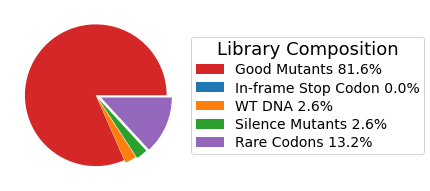

In [8]:
# In the raw alignment dataframe, filter out the reads where the DNA alignment length is the same as the input
# target WT DNA sequence, and no insertions or deletions were detected. 

# Define effective DNA library

df_effective_DNAlib=mutlib.effective_DNAlib(df, target)

# Calcuate the composition of the library, which includes the fraction of good mutants, the fraction of mutatns 
# that contain in-frame stop codons, wt DNA and silence mutants, as well as mutants that contain rare codons.
lib_comp = mutlib.library_composition(df_effective_DNAlib, target)

# Plot library_composition as a pie chart. The pie chart only includes reads with 
mutlib.plot_library_composition(lib_comp, figname=None)

In [9]:
# Define effective DNA library by taking the original df and filtering out the reads where the DNA alignment length is the same as the input
# target WT DNA sequence, and no insertions or deletions were detected. 
df_effective_AAlib=mutlib.effective_AAlib(df, target)

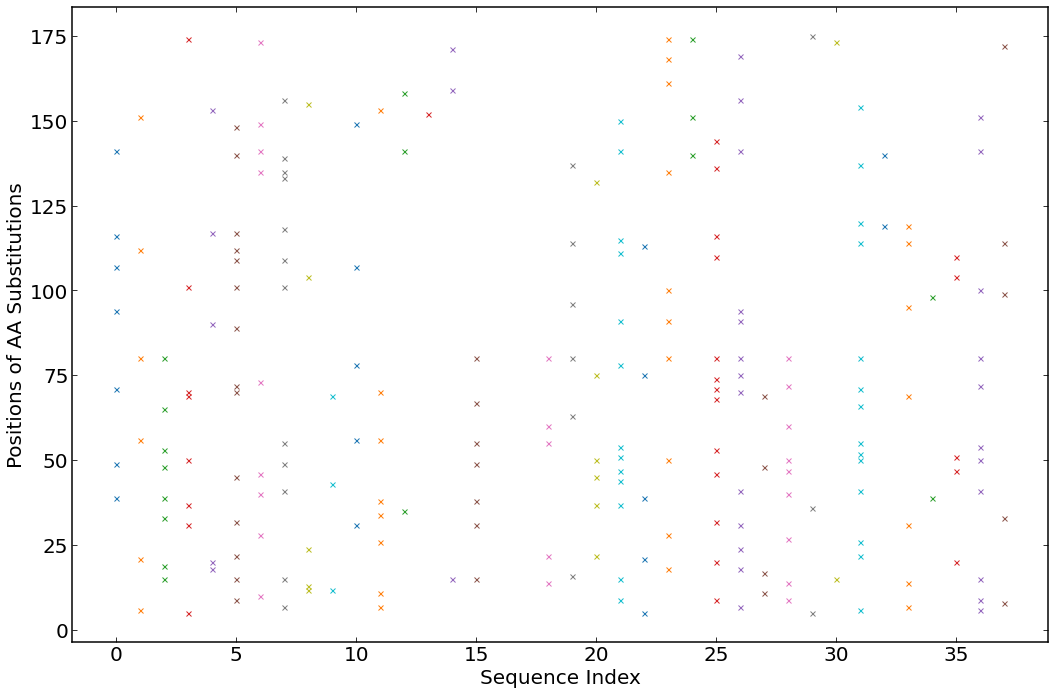

In [10]:
# Plot the AA mutations found in reads in the library, each column representing one read
mutlib.plot_mutations_per_read(df_effective_AAlib, interval=1, marker= 'x', markersize=5)

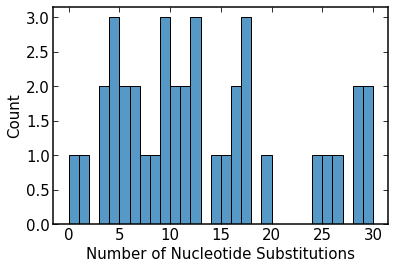

(array([1, 1, 0, 2, 3, 2, 2, 1, 1, 3, 2, 2, 3, 0, 1, 1, 2, 3, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 2, 2]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]))

In [11]:
# Plot the per-read count of NT substitutions
mutlib.plot_hist_NT_substitutions(df_effective_AAlib)

(array([2, 1, 3, 5, 1, 7, 3, 3, 3, 2, 1, 1, 1, 5]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]))

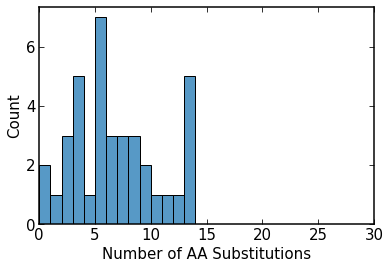

In [12]:
# Plot the per-read count of AA substitutions
mutlib.plot_hist_AA_substitutions(df_effective_AAlib)

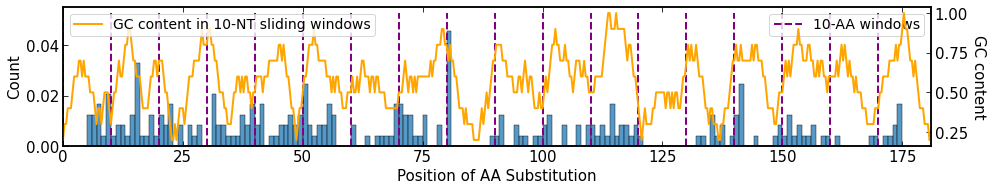

In [13]:
# Plot the per-AA position count of mutations in the library
mutlib.plot_bar_substitutions_loc(df_effective_AAlib, vline_positions= np.arange(0,180,10),wtseq=target[20:-20], GC_content=True, ntbefore=5, ntafter=5, stat='density')

In [14]:
# Print the descriptive statistics of the AA library
mutlib.descriptive_dict(df_effective_AAlib, column_name='num_AA_substitutions')

{'count': 38.0,
 'mean': 6.368421052631579,
 'std': 3.962125096129935,
 'min': 0.0,
 '25%': 3.0,
 '50%': 5.5,
 '75%': 8.75,
 'max': 14.0}

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


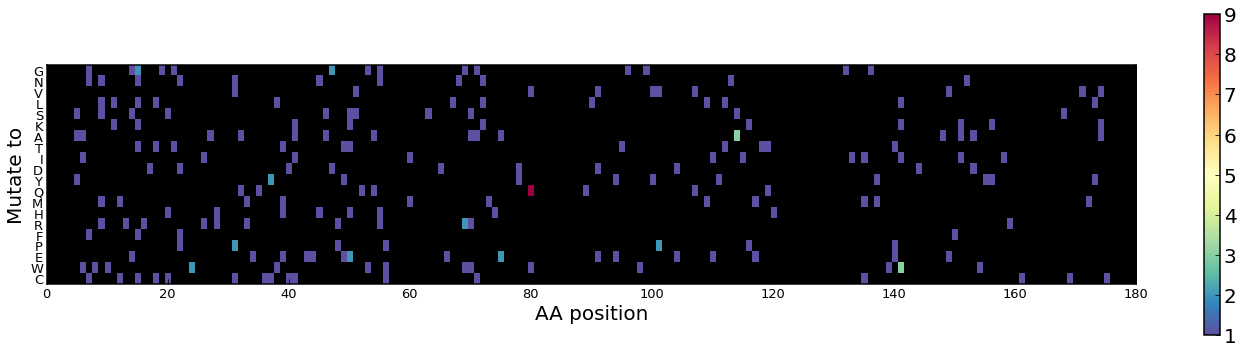

In [15]:
# Print the alignment matrix of the AA library
df_matrix_mutto_loc=mutmatrix.matrix_mutto_loc(df_effective_AAlib, target=target)
mutmatrix.plot_mut_loc_matrix(df_matrix_mutto_loc)

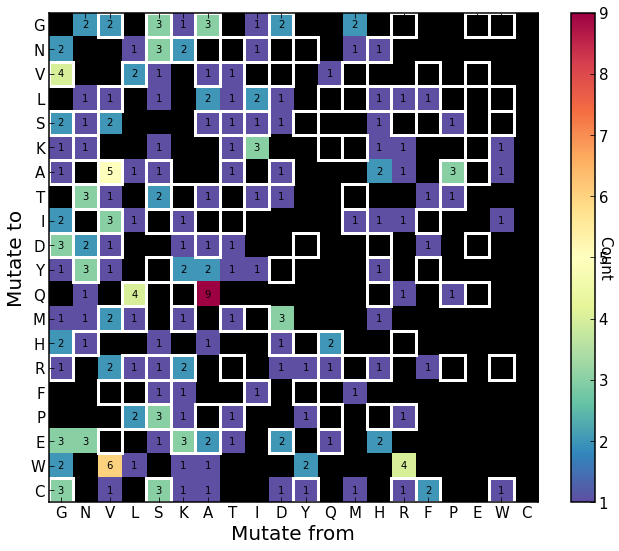

In [16]:
df_matrix_mutto_AA=mutmatrix.matrix_mutto_AA(df_matrix_mutto_loc, target)
mutmatrix.plot_matrix_mutto_AA(df_matrix_mutto_AA, theoretical_mutto_AA='epPCR', target=target)

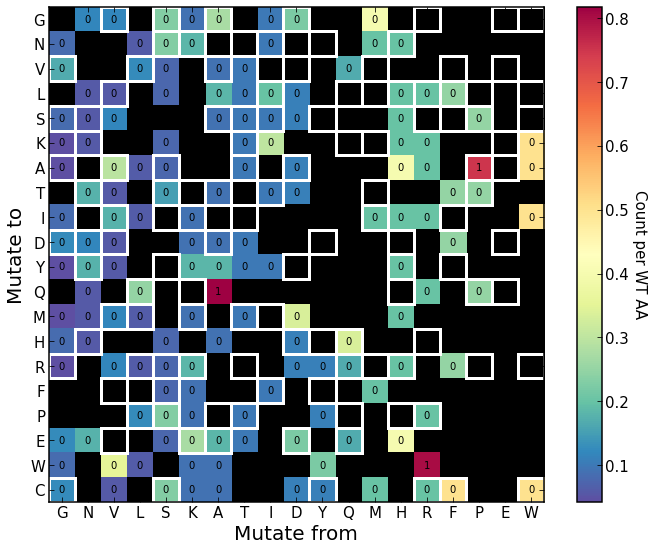

In [17]:
mutmatrix.plot_matrix_mutto_AA_norm(df_matrix_mutto_AA, target=target, theoretical_mutto_AA='epPCR')

## Package left to do:
left to do:

1. EP_AA2AA.ipynb to generate the theoretical epPCR AA_to_AA.npy, and to generate the theoretical matrix plots. integrate this part to the current mutamttrix.py module using the EP_AA2AA notebook. Done


2. Finish the simulated_library_analyses tests, then integrate these tests with other unit tests. 


3. parallel code! From here develop everything on cluster.

4. Remove all imports in the first code cell.


5. Make a separate run scrip that does everything in documentation but automatically generates all of the outputs and save in a separate folder. 

7. readme, license, requirements.txt


6. Figure out installation and upload to git!!




